# <center>Music Recommendation System</center>

<u><h3>Group Members</h3></u>
Shartil Shartilov, 22085025<br>
Riaz Khan, 23068308<br>
Najeeb Ullah, 23061856
<hr>

## Data Preprocessing

* Pip Install Commands

In [1]:
%pip install shapely
%pip install node2vec

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


* Libraries

In [2]:
import os
import json
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from shapely.prepared import prep
from shapely.geometry import mapping, shape, Point

from node2vec import Node2Vec
from sklearn.neighbors import NearestNeighbors

* Const Values

In [3]:
# column const values
YEAR_COLUMN = "year"
TEMPO_COLUMN = "tempo"
LOUDNESS_COLUMN = "loudness"
DURATION_COLUMN = "duration"
SONG_HOTTTNESSS_COLUMN = "song_hotttnesss"
ARTIST_HOTTTNESSS_COLUMN = "artist_hotttnesss"
ARTIST_FAMILIARITY_COLUMN = "artist_familiarity"
DECADE_COLUMN = "decade"

# numeric columns name list
NUMERIC_COLUMNS_LIST = [
    YEAR_COLUMN,
    TEMPO_COLUMN,
    LOUDNESS_COLUMN,
    DURATION_COLUMN,
    SONG_HOTTTNESSS_COLUMN,
    ARTIST_HOTTTNESSS_COLUMN,
    ARTIST_FAMILIARITY_COLUMN,
    DECADE_COLUMN
]

# string column names
SONG_TITLE_COLUMN = "song_title"
COUNTRY_COLUMN = "country"

# artist location columns 
ARTIST_LONGITUDE_COLUMN = "artist_longitude"
ARTIST_LATITUDE_COLUMN = "artist_latitude"
ARTIST_LOCATION_COLUMN = "artist_location"
UNKNOWN_COUNTRY_VALUE = "unknown"

# id columns 
ARTIST_ID_COLUMN = "artist_id"
SONG_ID_COLUMN = "song_id"

# const path values
MUSIC_DATA_FOLDER_PATH = "../Music Data/"
MODELS_FOLDER_PATH = "../models/"

* Methods

In [4]:
def get_attribute_node_name(node_type, node_value):
    "This method returns concatenated string of node type and node value"
    return f"{node_type} {node_value}"

In [5]:
def get_country(lon, lat, countries_dict):
    "This method returns country name based on latitude and longitude values"
    point = Point(lon, lat)
    for country, geom in countries_dict.items():
        if geom.contains(point):
            return country

    return UNKNOWN_COUNTRY_VALUE

First, let's load Songs & Artists datasets

In [6]:
raw_songs_dataset = pd.read_csv("../Data/songs_dataset.csv")
raw_artists_dataset = pd.read_csv("../Data/artist_terms.csv")

Merging datasets based on artist_id<br>
In the following cell, duplicate rows based on `artist_id` will be removed and only the first value will be saved.

In [7]:
# Remove duplicates from the artist dataset based on artist_id
raw_artists_dataset = raw_artists_dataset.drop_duplicates(subset=ARTIST_ID_COLUMN, keep='first')

# Merge the datasets on artist_id
raw_music_dataset = pd.merge(raw_songs_dataset, raw_artists_dataset, on=ARTIST_ID_COLUMN, how='left')

In the above cell, the datasets were merged based on artist_id using a left join.<br>
This join means that all the keys from the left dataframe (in this case, the raw_songs_dataset dataframe) will be included in the merged dataframe, and only the matching keys from the right dataframe (in this case, the artist_dataset dataframe) will be added.
<br><br>
In other words, all rows from the left dataframe (raw_songs_dataset) are retained.<br>
If there are matching keys (in this case, artist_id) in the right dataframe (artist_dataset), the corresponding data from the right dataframe will be added to the merged dataframe.
If there are no matching keys in the right dataframe, the corresponding columns in the merged dataframe will be filled with NaN (missing values).

Here is the merged raw dataframe at first glance

In [8]:
raw_music_dataset.head()

,song_id,song_title,year,release,tempo,loudness,duration,song_hotttnesss,artist_id,artist_name,artist_latitude,artist_longitude,artist_location,artist_hotttnesss,artist_familiarity,term
0,SOVFVAK12A8C1350D9,Tanssi vaan,1995.0,Karkuteillä,150.778,-10.555,156.55138,0.299877,ARMVN3U1187FB3A1EB,Karkkiautomaatti,NaN,NaN,NaN,0.356992,0.439604,pop rock
1,SOGTUKN12AB017F4F1,No One Could Ever,2006.0,Butter,177.768,-2.060,138.97098,0.617871,ARGEKB01187FB50750,Hudson Mohawke,55.8578,-4.24251,"Glasgow, Scotland",0.437504,0.643681,broken beat
2,SOBNYVR12A8C13558C,Si Vos Querés,2003.0,De Culo,87.433,-4.654,145.05751,NaN,ARNWYLR1187B9B2F9C,Yerba Brava,NaN,NaN,NaN,0.372349,0.448501,cumbia
3,SOHSBXH12A8C13B0DF,Tangle Of Aspens,NaN,Rene Ablaze Presents Winter Sessions,140.035,-7.806,514.29832,NaN,AREQDTE1269FB37231,Der Mystic,NaN,NaN,NaN,0.000000,0.000000,hard trance
4,SOZVAPQ12A8C13B63C,"Symphony No. 1 G minor ""Sinfonie Serieuse""/All...",NaN,Berwald: Symphonies Nos. 1/2/3/4,90.689,-21.420,816.53506,NaN,AR2NS5Y1187FB5879D,David Montgomery,NaN,NaN,NaN,0.109626,0.361287,ragtime


In [9]:
raw_music_dataset.isna().sum()

song_id                    0
song_title                 0
year                  484270
release                    5
tempo                      0
loudness                   0
duration                   0
song_hotttnesss       417782
artist_id                  0
artist_name                0
artist_latitude       641766
artist_longitude      641766
artist_location       487546
artist_hotttnesss         12
artist_familiarity       185
term                    3767
dtype: int64

In [10]:
raw_music_dataset.isna().sum().sum()

2677099

It is clear that the raw dataframe contains plenty of rows with missing data.<br>
These rows will be deleted, since we require rows with complete data for our system.

In [11]:
music_dataset = raw_music_dataset.dropna()

In [12]:
len(music_dataset)

126905

Our system does not require a vast amount of songs.<br>
Instead we will select a small portion of over 1000 songs to work with.

In [13]:
print(music_dataset.shape)

# returns dataframe with (1058, 13)
music_dataset = music_dataset.iloc[::120]

print(music_dataset.shape)

(126905, 16)
(1058, 16)


Now, let's introduce a new column "country" based on Latitude and Longitude of each artist.

The code cell below is used to load geographical data from a local GeoJSON file, process it, and subsequently determine which country a given set of latitude and logitude coordinates falls into. The country names extracted from GeoJSON file are then inserted into a new column in a dataset.

- The "json.load" function reads the file and convert it into a Python dictionary ('geojson_data').

- An empty dictionary named 'countries' is initiated to store the coordinated data associated with each country.

- The script iterates over each feature in the 'features' array of the 'geojson_data'. Each features represents a country.

- For each feature, the geometry ('geom') and the administrative name of the country is extracted.

- The geometry is then processed with a function 'prep' applied to 'shape(geom)'. This likely involves creating a geometric shape from the geometry data and preparing it for fast spatial queries. The processed geometry is stored in the 'countries' dictionary with the country name as key.

- A function 'get_country' is defined which takes longitudes ('lon') and latitude ('lat') as arguments and creates a ('Point') object from coordinates.

- It then iterates  over the 'countries' dictionary and check whether the point is contained within any of the country geometrics using the 'contains' method of the geometry.

- If a containing country is found, the function returns the country's name. if no containing country is found, it returns a value UNKNOWN_COUNTRY_VALUE
- A new column in the dataset ('music_dataset') is populated by applying 'get_country' function to each row. In this way the country column is added to music_dataset based on latitude and logitude columns.

In [14]:
# fetch and process the geojson data from a local file
with open(r'../Data/countries.geojson.json', 'r') as file:
    geojson_data = json.load(file)

In [15]:
# fill countries dict with data
countries_dict = {}
for feature in geojson_data["features"]:
    geom = feature["geometry"]
    country = feature["properties"]["ADMIN"]
    countries_dict[country] = prep(shape(geom))

In [16]:
# apply the function to create a new 'country' column
music_dataset[COUNTRY_COLUMN] = music_dataset.apply(
    lambda row: get_country(
        row[ARTIST_LONGITUDE_COLUMN], 
        row[ARTIST_LATITUDE_COLUMN],
        countries_dict), 
        axis=1
    )

Now, let's delete redundant columns in the music dataframe and songs with unknown coutry value.

In [17]:
music_dataset = music_dataset.drop(
    [
        ARTIST_LATITUDE_COLUMN,
        ARTIST_LONGITUDE_COLUMN,
        ARTIST_LOCATION_COLUMN,
        SONG_ID_COLUMN,
        ARTIST_ID_COLUMN
    ], 
    axis=1)


music_dataset = music_dataset[music_dataset[COUNTRY_COLUMN] != UNKNOWN_COUNTRY_VALUE]
music_dataset.reset_index(drop=True, inplace=True)

Let's select a final batch of 1000 songs to use in our recommendation system.

In [18]:
# returns dataframe with 1000 songs
music_dataset = music_dataset.iloc[:1000]

print(music_dataset.shape)

(1000, 12)


Let's expend the music dataset by adding a decade column.

In [19]:
music_dataset[YEAR_COLUMN] = music_dataset[YEAR_COLUMN].astype(int)
music_dataset = music_dataset.assign(decade=lambda row: (row[YEAR_COLUMN].astype(int) // 10) * 10)
music_dataset.head()

,song_title,year,release,tempo,loudness,duration,song_hotttnesss,artist_name,artist_hotttnesss,artist_familiarity,term,country,decade
0,No One Could Ever,2006,Butter,177.768,-2.060,138.97098,0.617871,Hudson Mohawke,0.437504,0.643681,broken beat,United Kingdom,2000
1,Don't Save It All For Christmas Day,2004,Merry Christmas With Love,127.397,-9.149,273.08363,0.732281,Clay Aiken,0.500596,0.852100,teen pop,United States of America,2000
2,White Lies,2006,Rocinate,92.103,-9.323,388.80608,0.417314,Ester Drang,0.330889,0.525616,shoegaze,United States of America,2000
3,Guess Who I Saw In Paris,1999,Sugar Me,105.054,-18.484,170.31791,0.368414,Claudine Longet,0.377489,0.563184,easy listening,France,1990
4,No More Birthdays (Phil Spector Folk) / San Fr...,2006,Born To Please,95.658,-6.141,280.45016,0.000000,Sound Team,0.368423,0.590111,art rock,United States of America,2000


In [20]:
# gather decade data for the knowledge graph creation in the upcoming steps
min_decade = music_dataset[DECADE_COLUMN].min()
max_decade = music_dataset[DECADE_COLUMN].max()
decade_array = np.arange(min_decade, max_decade + 10, 10, dtype=int)

Finally, let's save the processed dataset to a CSV file for future use.

In [21]:
if not os.path.isdir(MUSIC_DATA_FOLDER_PATH):
    os.mkdir(MUSIC_DATA_FOLDER_PATH)

music_dataset.to_csv(f"{MUSIC_DATA_FOLDER_PATH}/music_dataset.csv", mode='w+')

### Knowledge Graph Creation

* Methods

In [22]:
def min_max_normalize_column(df, column_name):
    "This method performs min max standardisation"
    min_val = df[column_name].min()
    max_val = df[column_name].max()
    
    if min_val == max_val:
        raise ValueError("Cannot normalize column when all values are the same.")
    
    df[column_name] = (df[column_name] - min_val) / (max_val - min_val)

Let's standardise the numeric columns in the music dataset.

In [23]:
normalized_music_dataset = music_dataset.copy()

for numeric_column in NUMERIC_COLUMNS_LIST:
    min_max_normalize_column(normalized_music_dataset, numeric_column)

normalized_music_dataset.head()

,song_title,year,release,tempo,loudness,duration,song_hotttnesss,artist_name,artist_hotttnesss,artist_familiarity,term,country,decade
0,No One Could Ever,0.927273,Butter,0.716171,0.961028,0.100247,0.620488,Hudson Mohawke,0.511917,0.671199,broken beat,United Kingdom,0.833333
1,Don't Save It All For Christmas Day,0.890909,Merry Christmas With Love,0.513242,0.763265,0.203325,0.735383,Clay Aiken,0.585741,0.906486,teen pop,United States of America,0.833333
2,White Lies,0.927273,Rocinate,0.371054,0.758411,0.292268,0.419082,Ester Drang,0.387169,0.537915,shoegaze,United States of America,0.833333
3,Guess Who I Saw In Paris,0.800000,Sugar Me,0.423229,0.502846,0.124340,0.369974,Claudine Longet,0.441695,0.580325,easy listening,France,0.666667
4,No More Birthdays (Phil Spector Folk) / San Fr...,0.927273,Born To Please,0.385376,0.847180,0.208987,0.000000,Sound Team,0.431087,0.610724,art rock,United States of America,0.833333


After standardising the data, we can create the knowledge graph for our system.

In [24]:
music_graph = nx.Graph()

In [25]:
for current_index, current_row in normalized_music_dataset.iterrows():
    # creating a data dict that contains numeric data for each song node
    node_data_dict = {}

    for current_column in NUMERIC_COLUMNS_LIST:
        # filling the data dict with the different numeric values for each song node
        node_data_dict[current_column] = current_row[current_column]

    # adding a song node to the graph with the numeric data
    music_graph.add_node(str(current_index), **node_data_dict)

In [26]:
# Adding empty nodes for the decades, which function as main nodes
# i.e., all the songs from 1950 will be connected to the 1950 node.
# This will save complex logic of connecting all the songs from the decade, and ensuring that the resulted graph will be less complicated.
for current_decade in decade_array:
    node_name = get_attribute_node_name(DECADE_COLUMN, current_decade)
    music_graph.add_node(node_name)

In [27]:
# connecting between the song nodes and the main decade nodes
for index, row in music_dataset.iterrows():
    current_decade = row[DECADE_COLUMN]
    node_name = get_attribute_node_name(DECADE_COLUMN, current_decade)
    music_graph.add_edge(node_name, str(index))

print(music_graph)

Graph with 1007 nodes and 1000 edges


Finally, let's plot the created Knowledge graph.<br>
Please note that this code was taken from the code notebook from week 8.

/Users/mac/anaconda3/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


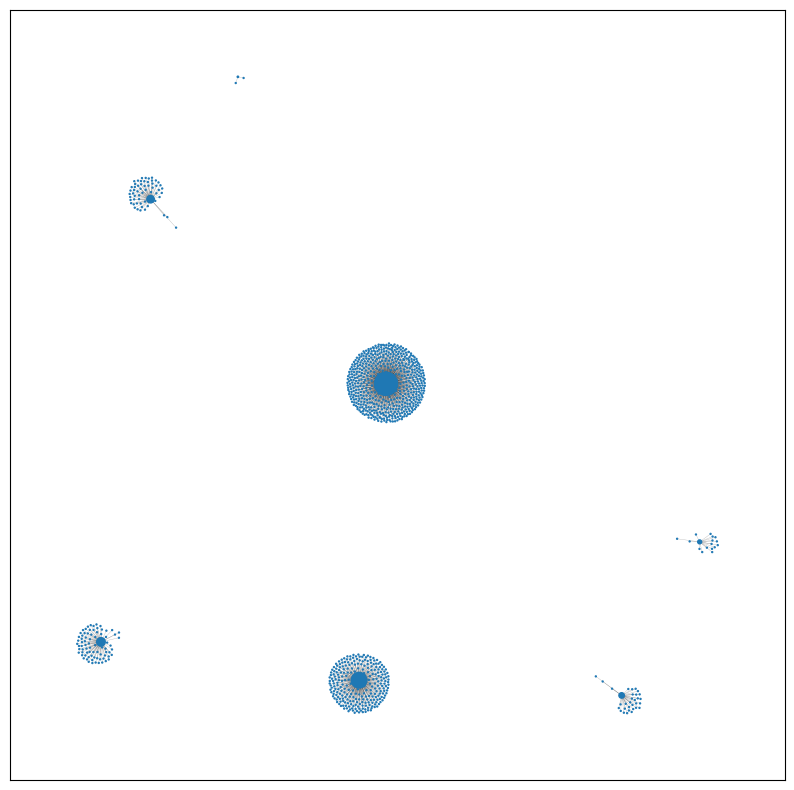

In [28]:
# use spring layout
pos = nx.spring_layout(music_graph)

# compute degree centrality
# degree represents the number of edges from each node,
# the centrality allows us to undertsand the more 'popular' nodes
cent = nx.degree_centrality(music_graph)
cent_array = np.array(list(cent.values()))

# size of nodes will be proportional to their popularity
node_size = list(map(lambda x: x * 500, cent.values()))

plt.figure(figsize=(10, 10))

#draw nodes
nodes = nx.draw_networkx_nodes(music_graph, pos, node_size=node_size,
                               cmap=plt.cm.plasma,
                               nodelist=list(cent.keys()))
# draw edges
edges = nx.draw_networkx_edges(music_graph, pos, width=0.25, alpha=0.3)

plt.show()

## Node Embedding and KNN Training

First, let's embed the song nodes using Node2Vec algorithm.

In [29]:
# precompute probabilities and generate walks - **ON WINDOWS ONLY WORKS WITH workers=1**
node2vec = Node2Vec(music_graph, dimensions=64, walk_length=10, num_walks=100, workers=4)

# embed graph nodes
model = node2vec.fit(window=10, min_count=1, batch_words=4)

Computing transition probabilities:   0%|          | 0/1007 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 25/25 [00:04<00:00,  5.38it/s]


In [30]:
# save embeddings for future use
model.wv.save_word2vec_format(f"{MODELS_FOLDER_PATH}/embedding")

# save model for future use
model.save(f"{MODELS_FOLDER_PATH}/node2vec_model")

Now, we can train an unsupervised version of the KNN classifier using the received embeddings.

In [31]:
nodes = list(music_graph.nodes())
embeddings = np.array([model.wv[str(node)] for node in nodes])
nearestNeighborSelector = NearestNeighbors(n_neighbors=6).fit(embeddings)

## Recommendation System User Interface

* Methods

In [32]:
def get_song_id(song_title):
    "This method returns music dataset ID of a given song name"
    matching_songs = music_dataset[music_dataset[SONG_TITLE_COLUMN].str.lower().str.contains(song_title.lower())]
    if not matching_songs.empty:
        return matching_songs.iloc[0].name
    return None

In [33]:
def recommend_songs(query):
    "This method displays song recommendations based on given song name"
    user_song_title = query
    song_id = get_song_id(user_song_title)

    if song_id is not None:
        user_song_embed = model.wv[str(song_id)]
        distances, indices = nearestNeighborSelector.kneighbors([user_song_embed])
        print("Similar songs:")
        similar_songs_df = music_dataset.loc[indices[0]]
        display(similar_songs_df)
    else:
        print("Song not found in the dataset.")

In [34]:
def recommend_songs_by_query(query_type, query):
    "This method displays song recommendations based on given query type and query value"
    filtered_music_df = music_dataset[music_dataset[query_type].astype(str).str.lower() == str(query).lower()]
    
    if len(filtered_music_df) > 0:
        chosen_song = filtered_music_df.sample(n=1)
        recommend_songs(chosen_song[SONG_TITLE_COLUMN].iloc[0])
    else:
        print("No songs found.")

Finally, let's setup the user interface of the system and start using it!

In [37]:
user_options_dict = {
    1 : ["song_title", "song title"],
    2 : ["artist_name", "artist name"],
    3 : ["decade", "decade"],
    4 : ["country", "country"],
    5 : ["term", "term"],
    6 : ["year", "year"]
}

In [36]:
try:
    print("Query by: song_title, artist_name, decade, country, term (genre) or year")
    input_text = "Enter your query type (provide number only):"

    for user_option_id, user_option in user_options_dict.items():
        input_text += f"\n{user_option_id} -> {user_option[0]}"

    user_query_input = int(input(input_text))
    query_type = user_options_dict[user_query_input][0]
    query = input(f"Enter value for the {user_options_dict[user_query_input][1]}")

    if query_type == 'song_title':
        recommend_songs(query)
    else:
        recommend_songs_by_query(query_type, query)
except ValueError as ex:
    print('Please provide valid input')

Query by: song_title, artist_name, decade, country, term (genre) or year
Similar songs:


,song_title,year,release,tempo,loudness,duration,song_hotttnesss,artist_name,artist_hotttnesss,artist_familiarity,term,country,decade
166,You Got Me Knockin',1999,Supernatural,78.721,-12.246,370.72934,0.473347,Robben Ford,0.383877,0.604820,blues-rock,United States of America,1990
472,Girl Falling Down,1999,Manage The Damage,91.001,-10.611,235.54567,0.249066,Jimmy Somerville,0.371165,0.595022,europop,United Kingdom,1990
665,World Go 'Round,1995,Tragic Kingdom,146.626,-6.837,248.24118,0.639792,No Doubt,0.557133,0.796498,ska punk,United States of America,1990
461,Why,1998,Got Another Answer?,121.603,-7.273,178.25914,0.000000,Looking Up,0.339996,0.537040,christian rock,United States of America,1990
766,Good Things,1991,Best Of Bodeans : Slash & Burn,118.508,-12.860,250.95791,0.675329,BoDeans,0.405967,0.617609,roots rock,United States of America,1990
306,Fact & Fiction,1999,Collected Ambient Tracks '94-'05,93.963,-10.153,172.09424,0.249066,Dj Spooky,0.390504,0.612327,illbient,United States of America,1990
